### Importing Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Loading Data

In [2]:
data = pd.read_csv('datasets/train.csv')
print(data.shape)
data.head()

(8068, 11)


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Data Preprocessing

In [3]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_cols:
    print(f'Column: {col}')
    print(f'Values: {data[col].unique()}\n')

Column: Gender
Values: ['Male' 'Female']

Column: Ever_Married
Values: ['No' 'Yes' nan]

Column: Graduated
Values: ['No' 'Yes' nan]

Column: Profession
Values: ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]

Column: Spending_Score
Values: ['Low' 'Average' 'High']

Column: Var_1
Values: ['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']

Column: Segmentation
Values: ['D' 'A' 'B' 'C']



In [4]:
print('Percentage of NaN values in each row:')
print(data.isnull().mean() * 100)

Percentage of NaN values in each row:
ID                  0.000000
Gender              0.000000
Ever_Married        1.735250
Age                 0.000000
Graduated           0.966782
Profession          1.536936
Work_Experience    10.275161
Spending_Score      0.000000
Family_Size         4.152206
Var_1               0.941993
Segmentation        0.000000
dtype: float64


In [5]:
data[categorical_cols] = SimpleImputer(strategy='most_frequent').fit_transform(data[categorical_cols])
data[numerical_cols] = SimpleImputer(strategy='median').fit_transform(data[numerical_cols])

### Visualizing Data

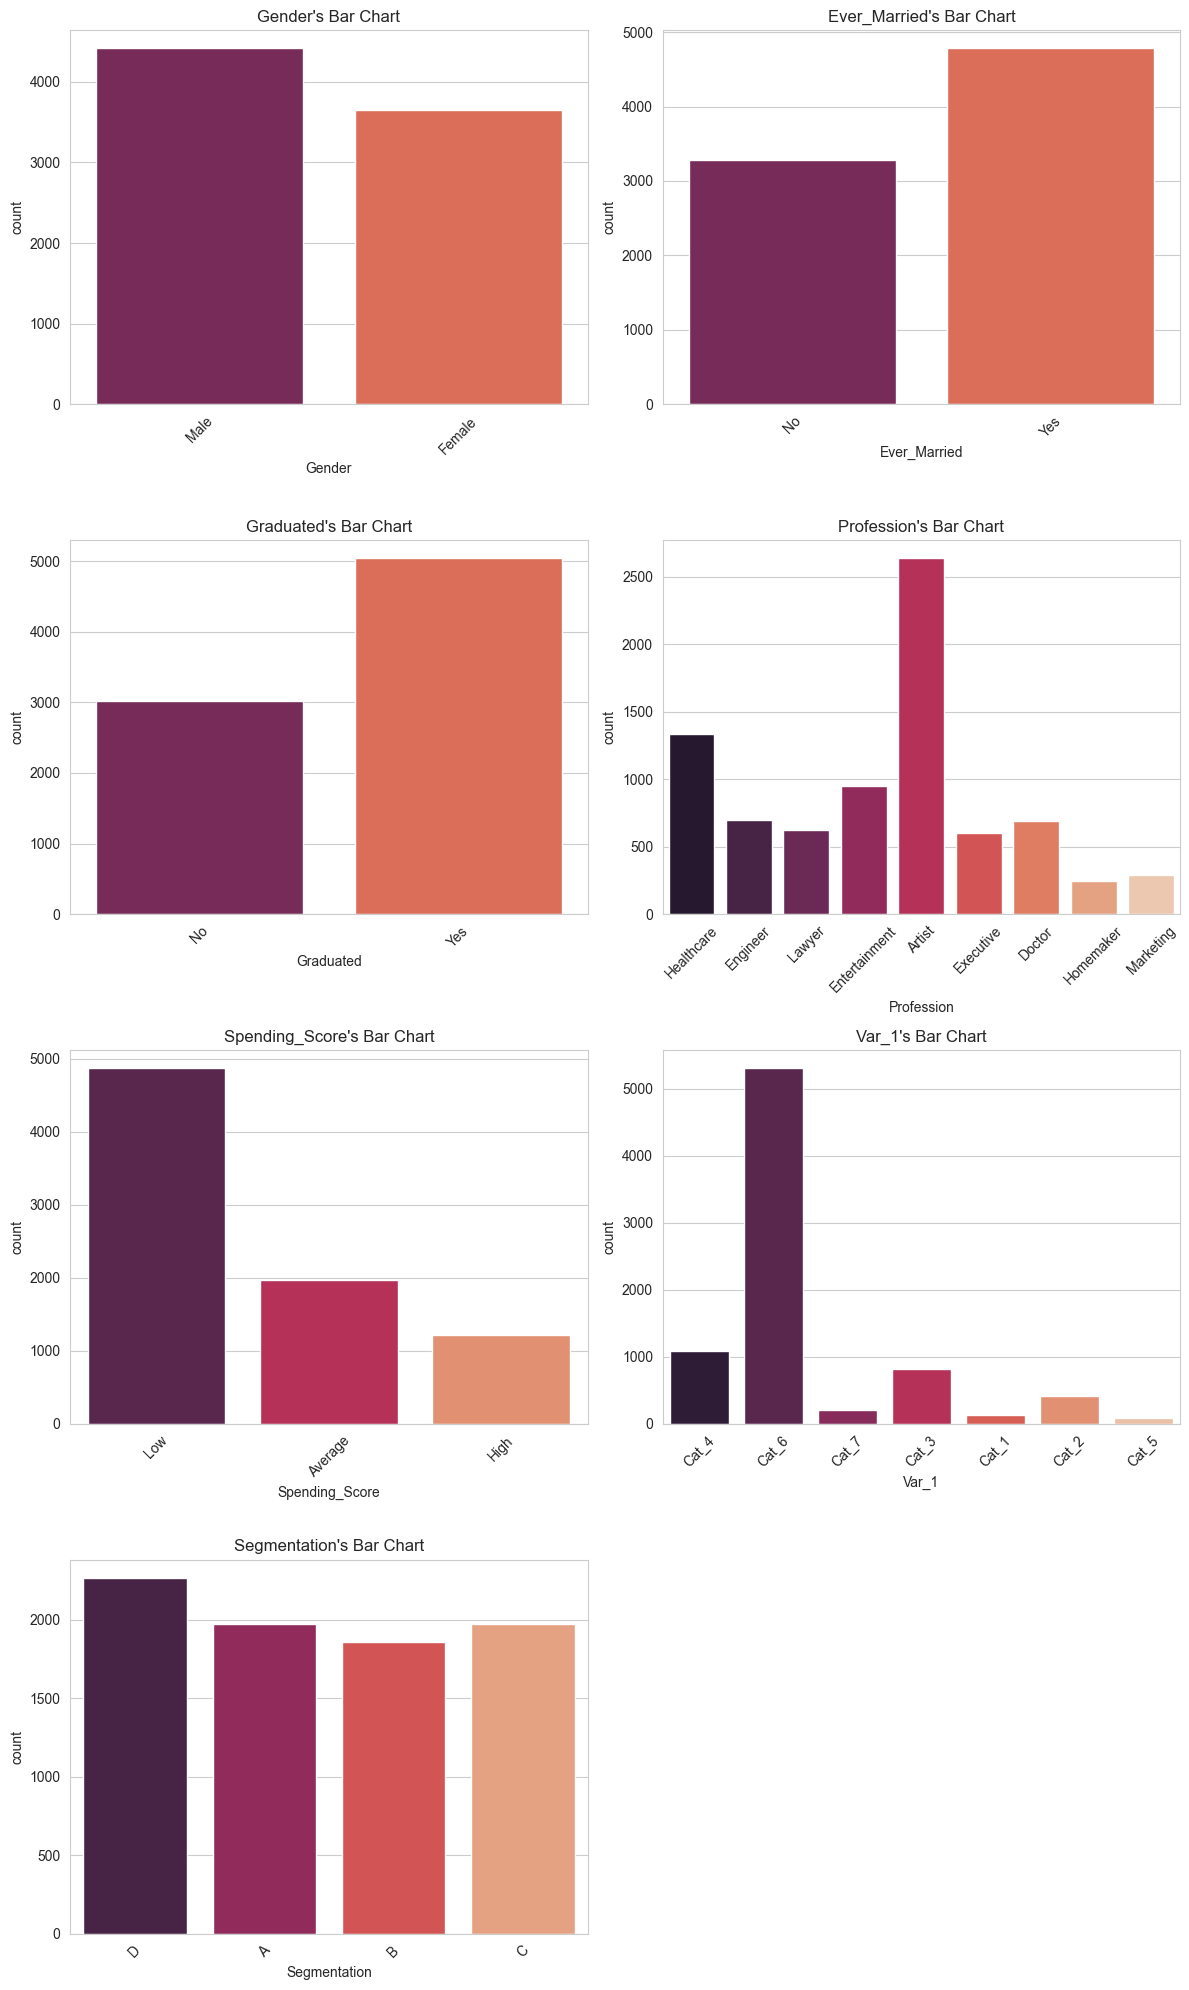

In [6]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 20))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(data=data, x=col, palette='rocket', hue=col, legend=False)
    plt.title(f'{col}\'s Bar Chart')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.savefig('visualizations/categ_cols_countplot.png', dpi=200)
plt.show()

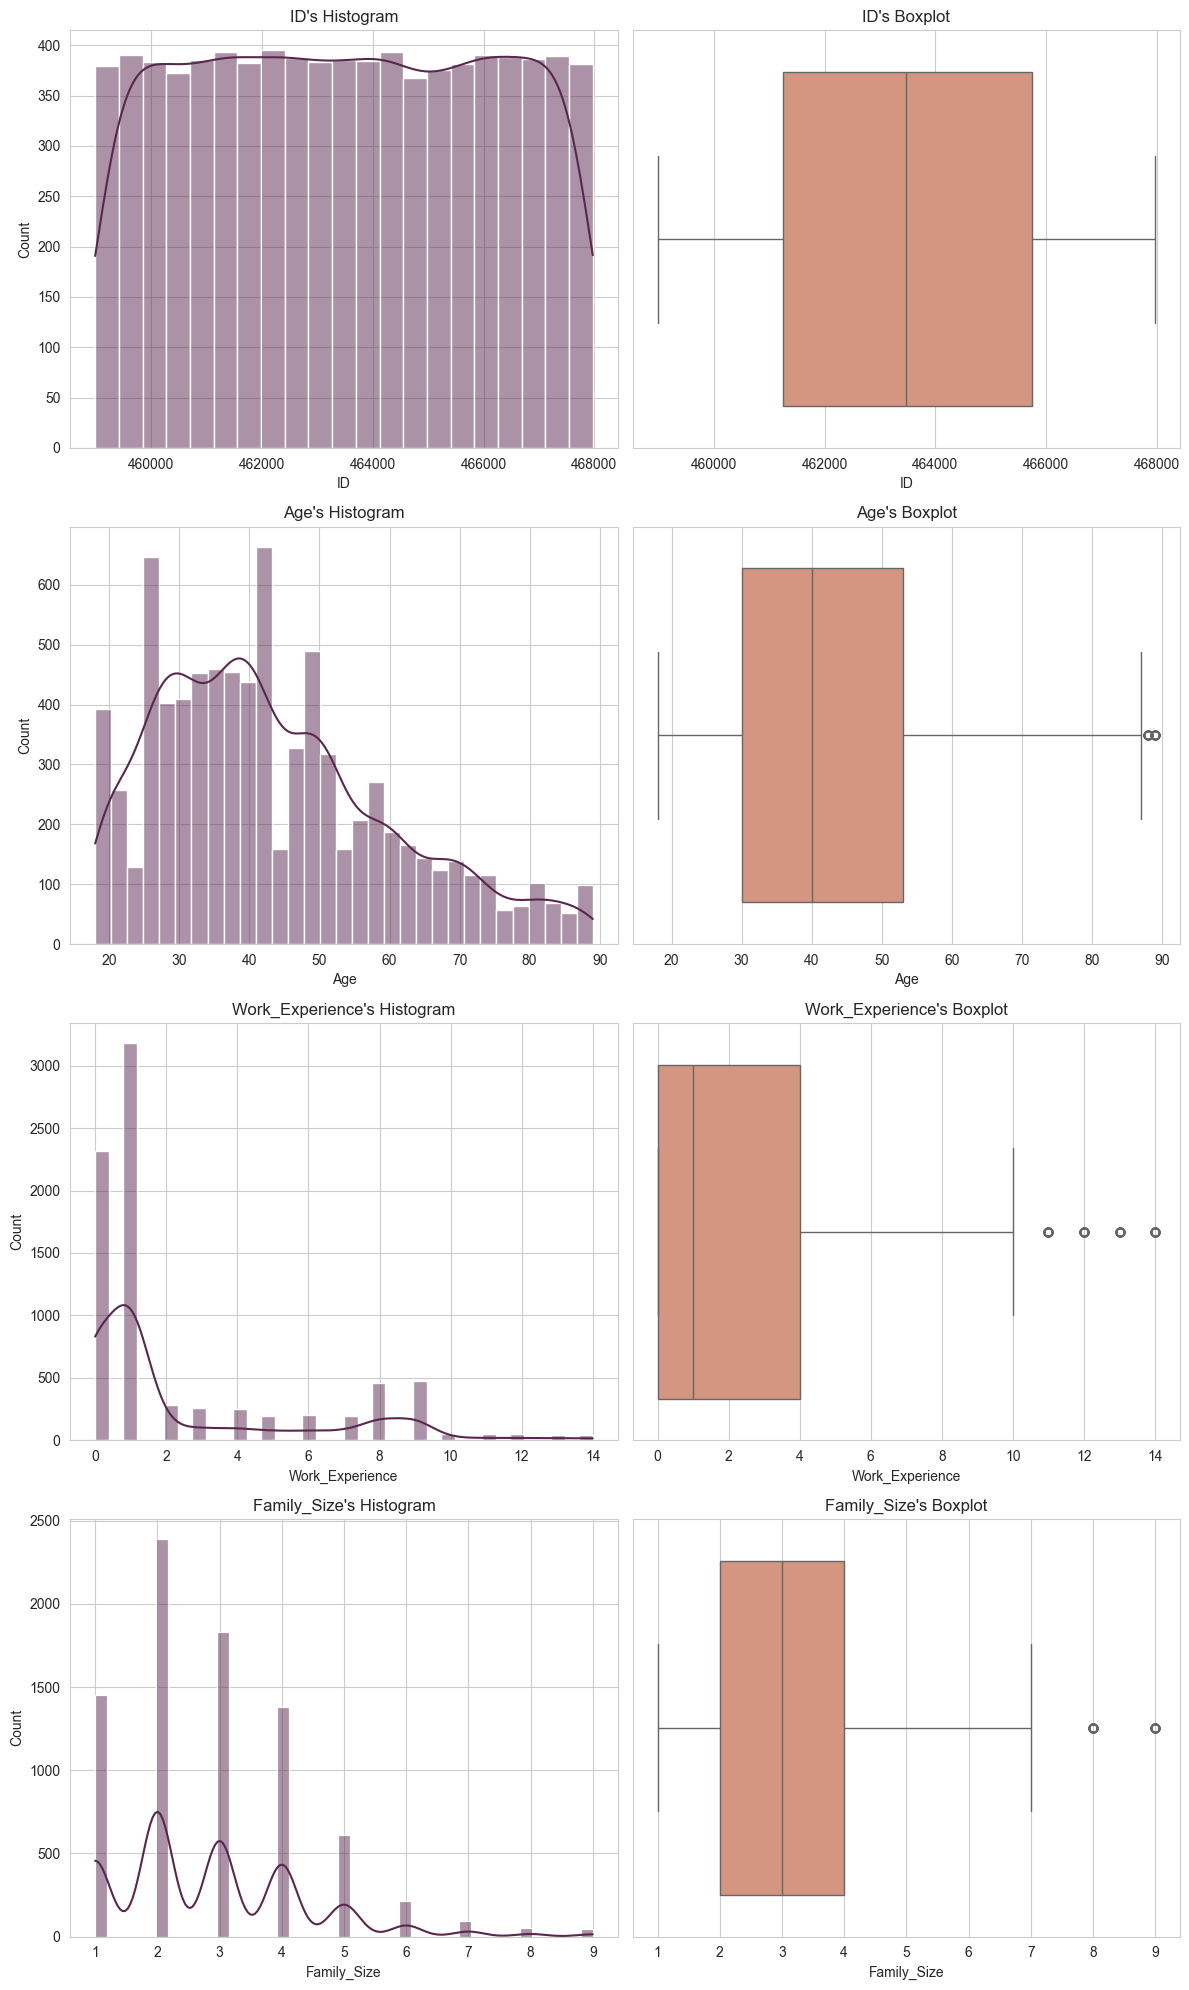

In [7]:
plt.figure(figsize=(12,len(numerical_cols)*5))
for i, col in enumerate(numerical_cols):
    plt.subplot(len(numerical_cols), 2, 2*i+1)
    sns.histplot(data[col], kde=True, color='#59274e')
    plt.title(f'{col}\'s Histogram')
    plt.subplot(len(numerical_cols), 2, 2*i+2)
    sns.boxplot(x=data[col], color='#e29072')
    plt.title(f'{col}\'s Boxplot')
    plt.tight_layout()
plt.savefig('visualizations/num_cols_hist_boxplot.png', dpi=200)
plt.show()

### Data Encoding

In [8]:
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
categorical_cols = categorical_cols.drop('Segmentation')

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categories = encoder.fit_transform(data[categorical_cols])
encoded_categ_feature_names = encoder.get_feature_names_out(categorical_cols)

encoded_categ_data = pd.DataFrame(encoded_categories, columns=encoded_categ_feature_names, index=data.index)
data_encoded = data.drop(categorical_cols, axis=1).join(encoded_categ_data)

data_encoded.head()

,ID,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,...,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7
0,462809.0,22.0,1.0,4.0,D,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,462643.0,38.0,1.0,3.0,A,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,466315.0,67.0,1.0,1.0,B,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,461735.0,67.0,0.0,2.0,B,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,462669.0,40.0,1.0,6.0,A,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Variance Inflation Factor

In [9]:
data_encoded_no_segmentation = data_encoded.drop(columns=['Segmentation'])

data_encoded_no_segm_constant = sm.add_constant(data_encoded_no_segmentation)

data_vif = pd.DataFrame()
data_vif['Variable'] = data_encoded_no_segm_constant.columns
data_vif['VIF'] = [variance_inflation_factor(data_encoded_no_segm_constant.values, i) for i in range(data_encoded_no_segm_constant.shape[1])]
data_vif = data_vif[data_vif['Variable'] != 'const']

print(data_vif)

                    Variable        VIF
1                         ID   1.012637
2                        Age   2.566126
3            Work_Experience   1.089836
4                Family_Size   1.277623
5                Gender_Male   1.172075
6           Ever_Married_Yes   2.432976
7              Graduated_Yes   1.274175
8          Profession_Doctor   1.229078
9        Profession_Engineer   1.289929
10  Profession_Entertainment   1.260322
11      Profession_Executive   1.527173
12     Profession_Healthcare   1.876534
13      Profession_Homemaker   1.132250
14         Profession_Lawyer   1.783179
15      Profession_Marketing   1.148292
16       Spending_Score_High   1.849901
17        Spending_Score_Low   2.414028
18               Var_1_Cat_2   3.981115
19               Var_1_Cat_3   6.467674
20               Var_1_Cat_4   8.020427
21               Var_1_Cat_5   1.626688
22               Var_1_Cat_6  14.073345
23               Var_1_Cat_7   2.470414


### Building Model

In [10]:
data_prepared = data_encoded_no_segm_constant.drop(columns=['Var_1_Cat_2', 'Var_1_Cat_3', 'Var_1_Cat_4', 'Var_1_Cat_5', 'Var_1_Cat_6', 'Var_1_Cat_7'], errors='ignore')

data_prepared.head()

,const,ID,Age,Work_Experience,Family_Size,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_High,Spending_Score_Low
0,1.0,462809.0,22.0,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,462643.0,38.0,1.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,466315.0,67.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,461735.0,67.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1.0,462669.0,40.0,1.0,6.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
def split_data(df):
    X = df.drop(['Segmentation'], axis=1)
    y = df['Segmentation']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    return X_train, X_test, y_train, y_test

In [12]:
def evaluate_models(X_train, X_test, y_train, y_test, type):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.fit_transform(X_test)

    models = {
        'Logistic_Regression': LogisticRegression(max_iter=1000),
        'KNN': KNeighborsClassifier(n_neighbors=10),
        'Naive_Bayes': GaussianNB(),
        'LDA': LinearDiscriminantAnalysis()
    }

    for name, model in models.items():
        if name in ['Naive Bayes']:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_prob = model.predict_proba(X_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_prob = model.predict_proba(X_test_scaled)

        model_corr_matrix = confusion_matrix(y_test, y_pred)
        # model_corr_matrix_percentage = model_corr_matrix.astype('float') / model_corr_matrix.sum(axis=1)[:,np.newaxis]*100

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        rocauc_score = roc_auc_score(pd.get_dummies(y_test), y_prob, multi_class='ovr')

        print(f'{'-'*50}')
        print(f'Model: {name}')
        print('\nConfusion Matrix:')
        print(model_corr_matrix)
        print(f'\nPrecision: {precision:.3f}')
        print(f'Recall: {recall:.3f}')
        print(f'F1 Score: {f1:.3f}')
        print(f'\nROC-AUC Score: {rocauc_score:.3f}')

        plt.figure(figsize=(8, 6))
        sns.heatmap(model_corr_matrix, annot=True, fmt='d', cmap='rocket', cbar=False,
                    xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig(f'visualizations/{name}_{type}_heatmap.png', dpi=160)
        plt.show()

Evaluating models on encoded data:

--------------------------------------------------
Model: Logistic_Regression

Confusion Matrix:
[[272  82 122 105]
 [184 105 226  59]
 [ 93  73 346  75]
 [137  29  30 483]]

Precision: 0.485
Recall: 0.498
F1 Score: 0.482

ROC-AUC Score: 0.758


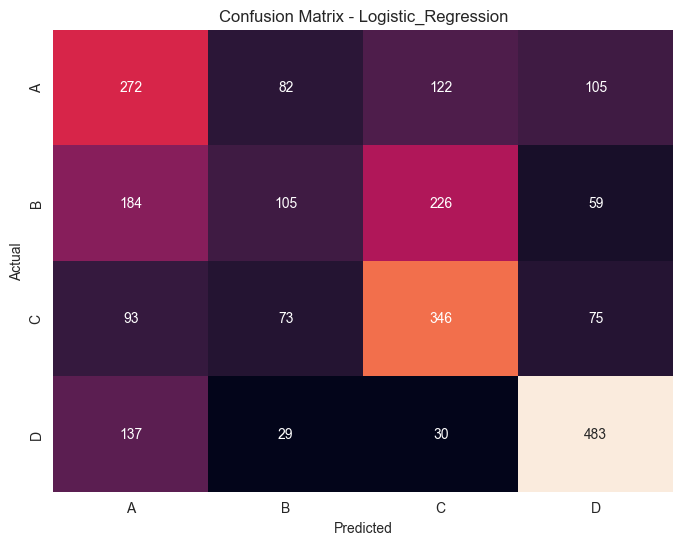

--------------------------------------------------
Model: KNN

Confusion Matrix:
[[242 132  94 113]
 [157 180 175  62]
 [ 80 130 304  73]
 [149  42  34 454]]

Precision: 0.483
Recall: 0.487
F1 Score: 0.485

ROC-AUC Score: 0.738


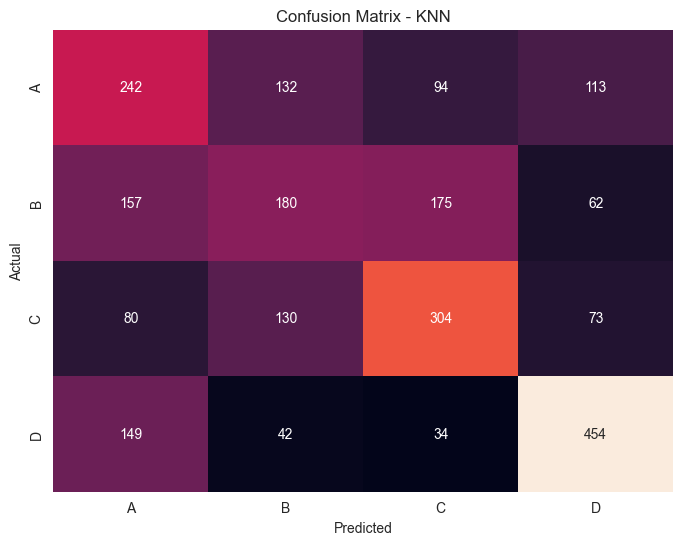

--------------------------------------------------
Model: Naive_Bayes

Confusion Matrix:
[[230  39 214  98]
 [131  67 317  59]
 [ 75  38 399  75]
 [150  28  73 428]]

Precision: 0.465
Recall: 0.464
F1 Score: 0.438

ROC-AUC Score: 0.718


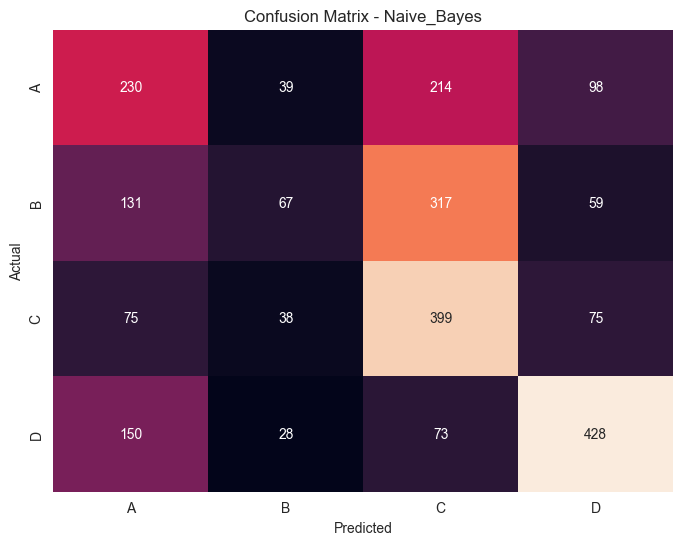

--------------------------------------------------
Model: LDA

Confusion Matrix:
[[305  91 115  70]
 [192 123 216  43]
 [105  83 333  66]
 [191  30  27 431]]

Precision: 0.496
Recall: 0.492
F1 Score: 0.485

ROC-AUC Score: 0.756


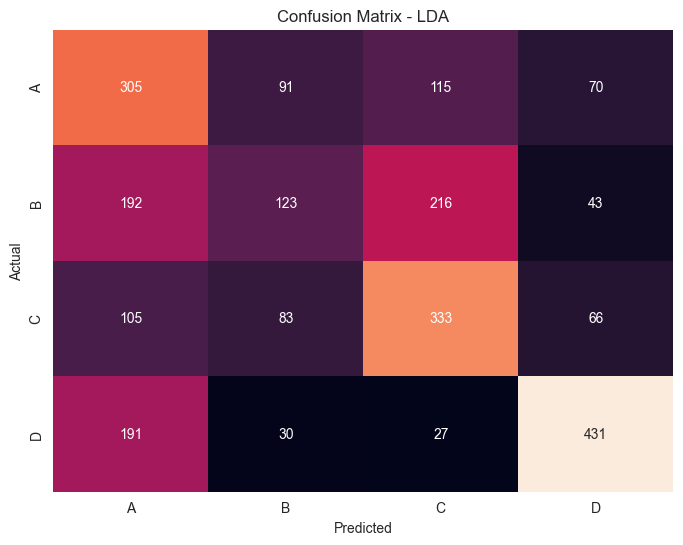


 ------------------------------------------------------------------------------------------------------------------------------------------------------ 


Evaluating models on cleaned data:

--------------------------------------------------
Model: Logistic_Regression

Confusion Matrix:
[[272  82 122 105]
 [184 105 226  59]
 [ 93  73 346  75]
 [137  29  30 483]]

Precision: 0.485
Recall: 0.498
F1 Score: 0.482

ROC-AUC Score: 0.758


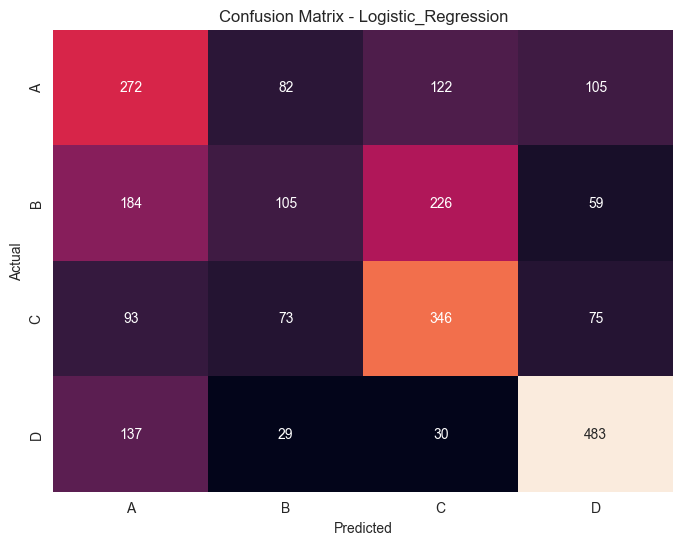

--------------------------------------------------
Model: KNN

Confusion Matrix:
[[242 132  94 113]
 [157 180 175  62]
 [ 80 130 304  73]
 [149  42  34 454]]

Precision: 0.483
Recall: 0.487
F1 Score: 0.485

ROC-AUC Score: 0.738


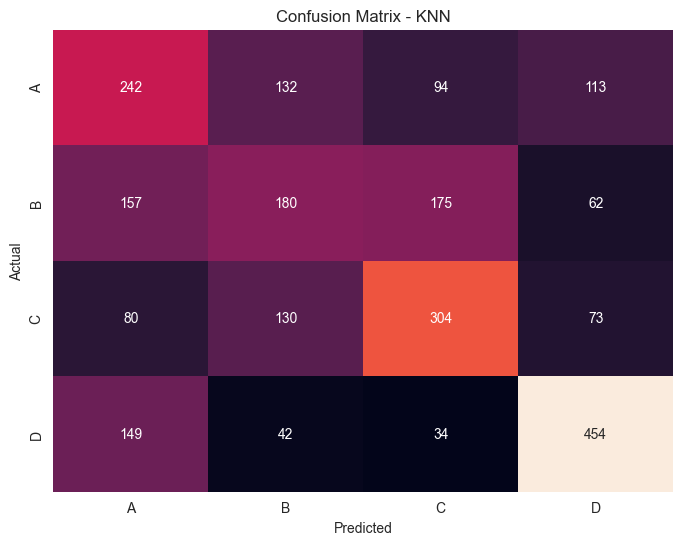

--------------------------------------------------
Model: Naive_Bayes

Confusion Matrix:
[[230  39 214  98]
 [131  67 317  59]
 [ 75  38 399  75]
 [150  28  73 428]]

Precision: 0.465
Recall: 0.464
F1 Score: 0.438

ROC-AUC Score: 0.718


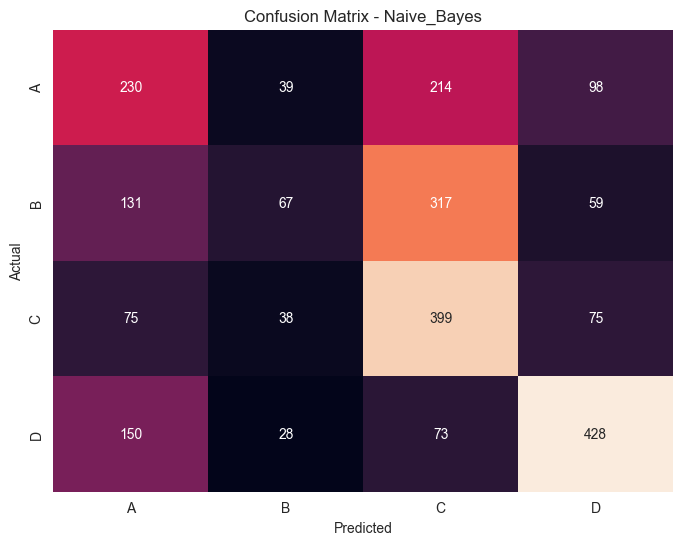

--------------------------------------------------
Model: LDA

Confusion Matrix:
[[305  91 115  70]
 [192 123 216  43]
 [105  83 333  66]
 [191  30  27 431]]

Precision: 0.496
Recall: 0.492
F1 Score: 0.485

ROC-AUC Score: 0.756


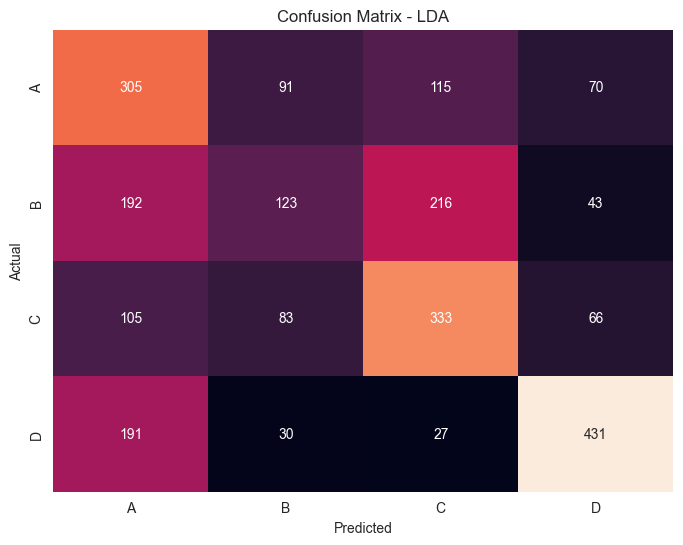

In [13]:
X_train_enc, X_test_enc, y_train_enc, y_test_enc = split_data(pd.concat([data_encoded_no_segmentation, data['Segmentation']], axis=1))
X_train_clean, X_test_clean, y_train_clean, y_test_clean = split_data(pd.concat([data_encoded_no_segm_constant, data['Segmentation']], axis=1))

print("Evaluating models on encoded data:\n")
evaluate_models(X_train_enc, X_test_enc, y_train_enc, y_test_enc, "encoded")

print('\n', '-'*150, '\n')

print('\nEvaluating models on cleaned data:\n')
evaluate_models(X_train_clean, X_test_clean, y_train_clean, y_test_clean, "cleaned")